In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import InceptionV3

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#https://drive.google.com/file/d/12700bE-pomYKoVQ214VrpBoJ7akXcTpL/view?usp=share_link

Mounted at /content/drive


In [3]:
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = train_data.astype("float32")
test_data = test_data.astype("float32")
#EfficientNetV2 models expect their inputs to be float tensors of pixels with values in the [0-255] range.

170498071/170498071 [==============================] - 2s 0us/step


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

In [6]:
train_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_gen.flow(X_train, y_train, batch_size=32)

In [7]:
input_shape = (32, 32, 3) #Cifar10 image size
resized_shape = (299, 299, 3) #Xception model input shape
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, resized_shape[:2]))(inputs) #Resize image to  size 224x224
    base_model = InceptionV3(include_top=False, input_shape=resized_shape, weights="imagenet")
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
model = build_model()
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490  

In [9]:


plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


history = model.fit(train_generator,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[plateau, earlystopping]
                   )
print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))

Epoch 1/10
1172/1172 [==============================] - 590s 472ms/step - loss: 0.7655 - accuracy: 0.7389 - val_loss: 0.4844 - val_accuracy: 0.8370 - lr: 0.0100
Epoch 2/10
1172/1172 [==============================] - 582s 497ms/step - loss: 0.4079 - accuracy: 0.8621 - val_loss: 0.3152 - val_accuracy: 0.8934 - lr: 0.0100
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8970
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
1172/1172 [==============================] - 582s 497ms/step - loss: 0.3043 - accuracy: 0.8970 - val_loss: 0.3380 - val_accuracy: 0.8869 - lr: 0.0100
Epoch 4/10
1172/1172 [==============================] - 583s 497ms/step - loss: 0.2031 - accuracy: 0.9303 - val_loss: 0.1815 - val_accuracy: 0.9371 - lr: 0.0070
Epoch 5/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9427
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004899999825283885.
1172/1172 [==========

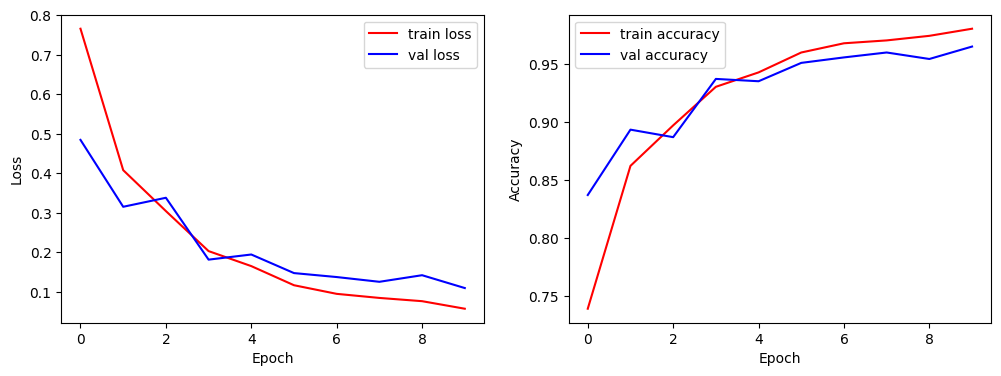

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

In [11]:
model.save("model.keras")

In [17]:
loaded_model = tf.keras.models.load_model("model.keras")
x = tf.random.uniform((299, 299, 3))

resized_x = tf.image.resize(x, (32, 32))
resized_x = tf.expand_dims(resized_x, axis=0)  # Add a batch dimension

assert np.allclose(model.predict(resized_x), loaded_model.predict(resized_x))
#

1/1 [==============================] - 1s 1s/step


313/313 [==============================] - 36s 115ms/step


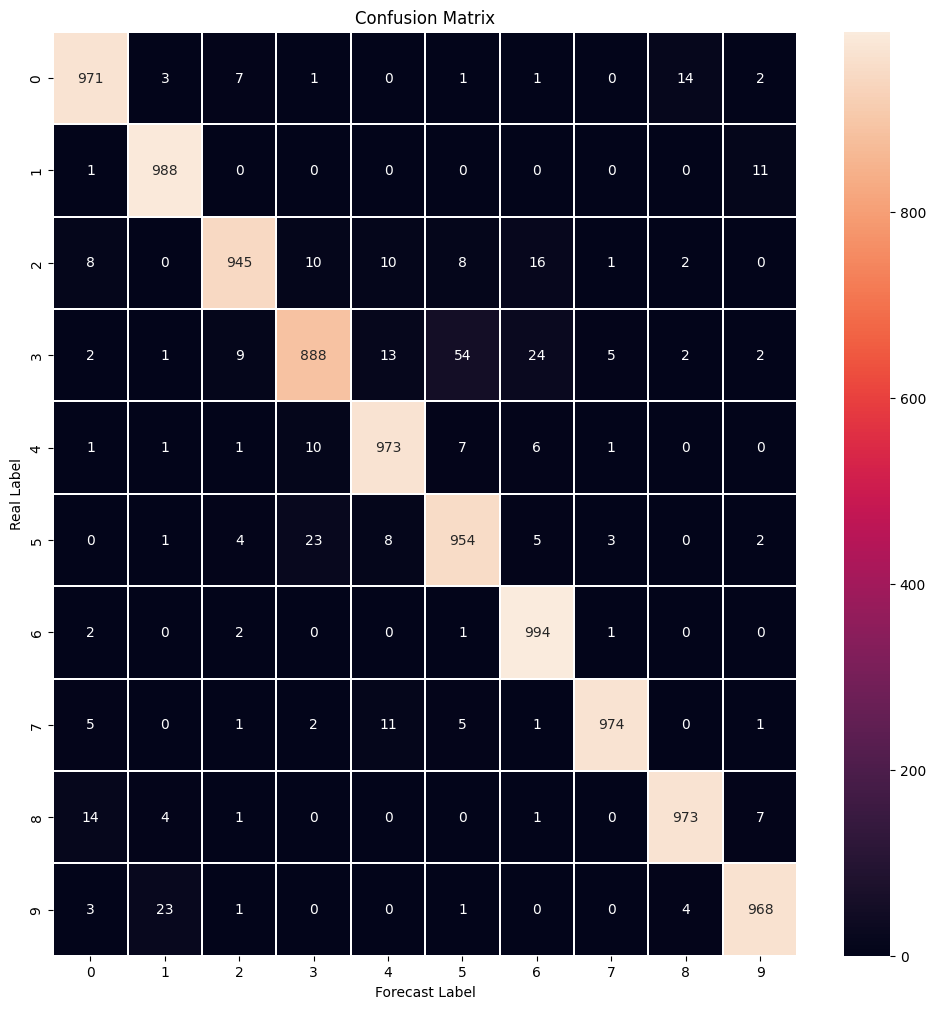

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_data)#10k images (10 classes x 1000 examples)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(test_label, axis = 1)
conf_matrix = confusion_matrix(y_true, y_pred_classes) 

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(conf_matrix, annot=True, linewidths=0.1, linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Forecast Label")
plt.ylabel("Real Label")
plt.title("Confusion Matrix")

plt.show()

In [19]:
model_dir = "CIFAR10_InceptionV3_(ACC_0.9628_LOSS_0.1097_)"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = f"/content/drive/MyDrive/data/{model_dir}"
tf.saved_model.save(model, model_path)